# Install Dependencies

In [2]:
import traceback
%pip install langchain-text-splitters==0.3.5 langchain==0.3.16 langchain_openai==0.3.2 langgraph==0.2.68 langchain-community==0.3.16 langchain-experimental==0.3.4 langchain-core==0.3.32 langchain-postgres==0.0.12 ipython==8.31.0

Note: you may need to restart the kernel to use updated packages.


# Setup Environment

In [3]:
import os

os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['LANGSMITH_API_KEY'] = os.getenv('LANGSMITH_API_KEY')

CONNECTION = os.getenv('CONNECTION')
COLLECTION_NAME = os.getenv('COLLECTION_NAME')

# Setup RAG

In [4]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_postgres import PGVector

llm = ChatOpenAI(model='gpt-4o-mini')
embeddings = OpenAIEmbeddings(model='text-embedding-3-small')

pg_vector_store = PGVector(
    embeddings=embeddings,
    collection_name=COLLECTION_NAME,
    connection=CONNECTION,
    use_jsonb=True,
)

# Ingest Test Data

In [9]:
from langchain_core.documents import Document

docs = [
    Document(
        page_content='there are cats in the pond',
        metadata={'id': 1, 'location': 'pond', 'topic': 'animals'},
    ),
    Document(
        page_content='ducks are also found in the pond',
        metadata={'id': 2, 'location': 'pond', 'topic': 'animals'},
    ),
    Document(
        page_content='fresh apples are available at the market',
        metadata={'id': 3, 'location': 'market', 'topic': 'food'},
    ),
    Document(
        page_content='the market also sells fresh oranges',
        metadata={'id': 4, 'location': 'market', 'topic': 'food'},
    ),
    Document(
        page_content='the new art exhibit is fascinating',
        metadata={'id': 5, 'location': 'museum', 'topic': 'art'},
    ),
    Document(
        page_content='a sculpture exhibit is also at the museum',
        metadata={'id': 6, 'location': 'museum', 'topic': 'art'},
    ),
    Document(
        page_content='a new coffee shop opened on Main Street',
        metadata={'id': 7, 'location': 'Main Street', 'topic': 'food'},
    ),
    Document(
        page_content='the book club meets at the library',
        metadata={'id': 8, 'location': 'library', 'topic': 'reading'},
    ),
    Document(
        page_content='the library hosts a weekly story time for kids',
        metadata={'id': 9, 'location': 'library', 'topic': 'reading'},
    ),
    Document(
        page_content='a cooking class for beginners is offered at the community center',
        metadata={'id': 10, 'location': 'community center', 'topic': 'classes'},
    ),
]

pg_vector_store.add_documents(docs, ids=[doc.metadata['id'] for doc in docs])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Test Queries

In [5]:
query_filter = {
    '$and': [
        {'id': {'$in': [1, 5, 2, 9]}},
        {'location': {'$in': ['pond', 'market']}},
    ]
}

pg_vector_store.similarity_search(
    'ducks',
    k=10,
    filter=query_filter,
)

[Document(id='2', metadata={'id': 2, 'topic': 'animals', 'location': 'pond'}, page_content='ducks are also found in the pond'),
 Document(id='1', metadata={'id': 1, 'topic': 'animals', 'location': 'pond'}, page_content='there are cats in the pond')]

# Agents Setup

In [6]:
from langgraph.graph import MessagesState


class State(MessagesState):
    next: str

# Tool setup

In [48]:
from langchain import hub
from langchain_core.tools import tool
from typing import Annotated
import traceback

prompt = hub.pull('rlm/rag-prompt')


@tool
def rag_tool(question: Annotated[str, 'User prompt'], ):
    """Use this as a knowledge base for some places and animal habitats."""

    try:
        retrieved_docs = pg_vector_store.similarity_search(question)
        docs_content = '\n\n'.join(doc.page_content for doc in retrieved_docs)
        messages = prompt.invoke({'question': question, 'context': docs_content})
        response = llm.invoke(messages)

        print(f'\nRAG\n{response.content}\n')
        return {'answer': response.content}
    except Exception as e:
        traceback.print_exc()
        return {'answer': f'Failed to execute. Error: {repr(e)}'}



@tool
def api_tool(question: Annotated[str, 'User prompt'], ):
    """Use this to get api result about coffee shops"""

    # API integration here

    return {'answer': 'Barista is the new coffee shop opened on Main Street'}

# Create Agents

In [49]:
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from typing import Literal

rag_agent = create_react_agent(llm, tools=[rag_tool])
api_agent = create_react_agent(llm, tools=[api_tool])

# members = ['rag', 'api']
members = ['rag']

options = members + ['FINISH']

system_prompt = (
    'You are a supervisor tasked with managing a conversation between the'
    f' following workers: {members}. Given the following user request,'
    ' respond with the worker to act next. Each worker will perform a'
    ' task and respond with their results and status. When finished,'
    ' respond with FINISH.'
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


def supervisor_node(state: State) -> Command[Literal[*members, '__end__']]:
    messages = [
                   {'role': 'system', 'content': system_prompt},
               ] + state['messages']
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response['next']
    if goto == 'FINISH':
        goto = END

    return Command(goto=goto, update={'next': goto})


def rag_node(state: State) -> Command[Literal['supervisor']]:
    result = rag_agent.invoke(state)
    return Command(
        update={
            'messages': [
                HumanMessage(content=result['messages'][-1].content, name='rag')
            ]
        },
        goto='supervisor',
    )


def api_node(state: State) -> Command[Literal['supervisor']]:
    result = api_agent.invoke(state)
    return Command(
        update={
            'messages': [
                HumanMessage(content=result['messages'][-1].content, name='api')
            ]
        },
        goto='supervisor',
    )


builder = StateGraph(State)
builder.add_edge(START, 'supervisor')
builder.add_node('supervisor', supervisor_node)
builder.add_node('rag', rag_node)
# builder.add_node('api', api_node)
graph = builder.compile()

# Graph

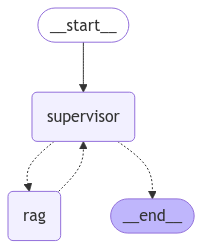

In [50]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [51]:
for s in graph.stream(
        {"messages": [("user", "where can i found ducks?")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'rag'}})
----
(('rag:e909f490-9462-4918-cd82-c1c18e917515',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_vzRj7m5nyyp3bBlJ1tM7ybLX', 'function': {'arguments': '{"question":"Where can I find ducks?"}', 'name': 'rag_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 60, 'total_tokens': 81, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fd8c05bc-84a0-43ef-8eb7-e84b281d1ecf-0', tool_calls=[{'name': 'rag_tool', 'args': {'question': 'Where can I find ducks?'}, 'id': 'call_vzRj7m5nyyp3bBlJ1tM7ybLX', 'type': 'tool_call'}], usage_metadata={'input_tokens':

In [43]:
graph.invoke(
    {"messages": [("user", "where can i found ducks?")]}, subgraphs=True
)

((),
 {'messages': [HumanMessage(content='where can i found ducks?', additional_kwargs={}, response_metadata={}, id='33343af9-49b6-483f-a814-3d6a4375de7d'),
   HumanMessage(content='Ducks can typically be found in a variety of habitats, including:\n\n1. **Wetlands**: Swamps, marshes, and seasonally flooded areas are prime duck habitats.\n2. **Ponds and Lakes**: Freshwater ponds and lakes provide feeding areas and nesting sites.\n3. **Rivers**: Many ducks are found near rivers and streams, especially during migration.\n4. **Estuaries**: Coastal areas where freshwater meets saltwater are important for some duck species.\n5. **Fields and Farmlands**: Ducks may also be seen in agricultural areas, especially during migration when they forage in harvested fields.\n\nLook for ducks in these environments, particularly during early morning or late afternoon when they are most active.', additional_kwargs={}, response_metadata={}, name='rag', id='ae8eb6d5-f2af-4caf-ab3f-c0feac4c9bd9')],
  'next':

In [52]:
rag_tool("where can i found ducks?")


RAG
You can find ducks in the pond.



{'answer': 'You can find ducks in the pond.'}